In [1]:
from copy import deepcopy
from typing import List

import numpy as np
import pandas as pd
import time

import colorcet as cc
import cv2
import faiss
import numpy as np
import skimage
import torch
from skimage.feature import graycomatrix
from simsearch.deeplearning.clustering.kmeans import kmeans

from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from torch import nn, seed
from umap import UMAP
from kornia.morphology import dilation

import os
import glob
from simsearch.deeplearning.features.extract_pixel_features import PixelFeatureExtractor
from simsearch.deeplearning.template_matching.compute_dis import DISCalculator
from simsearch.api.iterative_patch_selection.ips_config import PixelFeatureExtractorConfig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as aug
import torch.nn.functional as F


In [2]:
import time

import numpy as np
import torch
from torch.nn.functional import cosine_similarity


def initialize(X, num_clusters):
    """
    initialize cluster centers
    :param X: (torch.tensor) matrix
    :param num_clusters: (int) number of clusters
    :return: (np.array) initial state
    """
    num_samples = len(X)
    indices = np.random.choice(num_samples, num_clusters, replace=False)
    initial_state = X[indices]
    return initial_state


def kmeans(X, num_clusters, n_iter=100, tol=1e-5):
    # initialize
    t1 = time.time()
    initial_state = initialize(X, num_clusters)
    iteration = 0

    while iteration < n_iter:
        dis = pairwise_l2(X, initial_state)  # pairwise_cosine
        # print(dis.min(), dis.max())
        choice_cluster = torch.argmin(dis, dim=1)
        initial_state_pre = initial_state.clone()

        for index in range(num_clusters):
            # selected = torch.nonzero(choice_cluster == index).squeeze()  # .to(device)
            selected = torch.where((choice_cluster == index) == True)[0].squeeze()
            selected = torch.index_select(X, 0, selected)

            if selected.shape[0] == 0:
                selected = X[torch.randint(len(X), (1,))]
            initial_state[index] = selected.mean(dim=0)

        center_shift = torch.sum(
            torch.sqrt(torch.sum((initial_state - initial_state_pre) ** 2, dim=1))
        )

        # print(center_shift.item())
        if torch.isnan(center_shift):
            print("ReInitializing...")
            print(torch.sum(torch.isnan(dis)).item())
            print(torch.sum(torch.isnan(initial_state)).item())
            initial_state = initialize(X, num_clusters)
            iteration = 0

        # increment iteration
        iteration = iteration + 1

        if center_shift ** 2 < tol:
            break
    print(
        f"KMeans Clustering Time: {time.time()-t1} sec. Stopped after {iteration} Iterations with shift {center_shift:.6f}"
    )
    return initial_state, choice_cluster, dis


def pairwise_l2(data1, data2):
    return torch.cdist(data1, data2)


def pairwise_cosine(data1, data2):
    data1 = data1 / torch.norm(data1, dim=1, keepdim=True)
    data2 = data2 / torch.norm(data2, dim=1, keepdim=True)
    similarity_mat = torch.matmul(data1, data2.T).clip(0, 1)
    cosine_dis = 1 - similarity_mat
    return cosine_dis



In [3]:
def max_locs(
    x, cluster_centers, sum_dis_filter, feature_norm, pool1d, unpool1d, feature_histogram, n_chunks
):
    with torch.no_grad():
        # print(x_norm.shape)
        sum_dis_filter.eval()
        d, w, h = x.shape
        # print(d, w, h)
        chunks = torch.split(x.reshape(d, w * h).transpose(1, 0), n_chunks, dim=0)

        nnf_idxs = []
        sim_vals = []
        one_hots = []
        sim_one_hots = []
        for i, chunk in enumerate(chunks):
            dist = -torch.cdist(cluster_centers, chunk)
            sim, idx = pool1d(dist.transpose(0, 1))
            one_hot = torch.ones_like(sim)
            one_hots.append(unpool1d(one_hot, idx))
            sim_one_hots.append(unpool1d(sim, idx))
            sim_vals.append(sim)
            nnf_idxs.append(idx)

        nnf_idxs = torch.cat(nnf_idxs).transpose(0, 1).reshape(1, w, h)
        sim_vals = torch.cat(sim_vals).transpose(0, 1).reshape(1, w, h)
        sim_one_hots = -torch.cat(sim_one_hots).transpose(0, 1).reshape(-1, w, h)
        print(sim_one_hots.min(), sim_one_hots.max())

        one_hots = torch.cat(one_hots).transpose(0, 1).reshape(-1, w, h)
        sum_hist = sum_dis_filter(one_hots.unsqueeze(0))
        a = (
            feature_histogram.unsqueeze(0)
            .unsqueeze(-1)
            .unsqueeze(-1)
            .repeat(1, 1, sum_hist.shape[2], sum_hist.shape[3])
        )
        # print(a.shape, sum_hist.shape)
        kl = torch.abs(a - sum_hist).sum(dim=1)  # / (w * h)
        # kl = -torch.sum(torch.min(a, sum_hist), dim=1)
        # kl = torch.kl_div(sum_hist, a, log_target=True).mean(dim=1)
        # kl = -torch.log(torch.sum(torch.sqrt(torch.abs(torch.mul(a, sum_hist))), dim = 1)+1e-40)#
        idxs = torch.where(kl == kl.max())
        # print(a.min(), a.max(), sum_hist.min(), sum_hist.max(), kl.min(), kl.max())

        # sim_one_hots = torch.cat(sim_one_hots).transpose(0, 1).reshape(-1, w, h)
        # sim_weight_hist = sum_dis_filter(sim_one_hots.unsqueeze(0)) / num_vectors

        # unique_hist1 = dis_calculation(one_hots)
    return -kl, idxs


def max_locs1(
    x, dist_calculator, sum_dis_filter, feature_norm, pool1d, unpool1d, feature_histogram, n_chunks
):
    with torch.no_grad():
        x_norm = x.norm(dim=0, keepdim=True)
        # print(x_norm.shape)
        dist_calculator.eval()
        sum_dis_filter.eval()
        d, w, h = x.shape
        # print(d, w, h)
        chunks = torch.split(x.reshape(d, w * h), n_chunks, dim=-1)
        norm_chunks = torch.split(x_norm.reshape(1, w * h), n_chunks, dim=-1)

        nnf_idxs = []
        sim_vals = []
        one_hots = []
        sim_one_hots = []
        for i, chunk in enumerate(chunks):
            dist = dist_calculator(chunk.unsqueeze(0)).squeeze(0)
            dist = dist / (feature_norm * norm_chunks[i])
            sim, idx = pool1d(dist.transpose(0, 1))
            one_hot = torch.ones_like(sim)
            # one_hot[sim < 0.90] = 0
            one_hots.append(unpool1d(one_hot, idx))
            sim_one_hots.append(unpool1d(sim, idx))
            sim_vals.append(sim)
            nnf_idxs.append(idx)

        nnf_idxs = torch.cat(nnf_idxs).transpose(0, 1).reshape(1, w, h)
        sim_vals = torch.cat(sim_vals).transpose(0, 1).reshape(1, w, h)
        sim_one_hots = -torch.cat(sim_one_hots).transpose(0, 1).reshape(-1, w, h)
        # print(sim_vals.min(), sim_vals.max())
        one_hots = torch.cat(one_hots).transpose(0, 1).reshape(-1, w, h)
        sum_hist = sum_dis_filter(one_hots.unsqueeze(0))
        a = (
            feature_histogram.unsqueeze(0)
            .unsqueeze(-1)
            .unsqueeze(-1)
            .repeat(1, 1, sum_hist.shape[2], sum_hist.shape[3])
        )
        # print(a.shape, sum_hist.shape)

        kl = torch.kl_div(a, sum_hist).mean(
            dim=1
        )  # -torch.log(torch.sum(torch.sqrt(torch.abs(torch.mul(a, sum_hist))), dim = 1))#
        idxs = torch.where(kl == kl.min())
        # print(a.min(), a.max(), sum_hist.min(), sum_hist.max(), kl.min(), kl.max())

        # sim_one_hots = torch.cat(sim_one_hots).transpose(0, 1).reshape(-1, w, h)
        # sim_weight_hist = sum_dis_filter(sim_one_hots.unsqueeze(0)) / num_vectors

        # unique_hist1 = dis_calculation(one_hots)
    return kl, idxs


KMeans Clustering Time: 0.5643491744995117 sec. Stopped after 17 Iterations with shift 0.000000
tensor(0.0082, device='cuda:0') tensor(5.3164, device='cuda:0')
torch.Size([2688]) torch.Size([256, 64])
tensor(-0., device='cuda:0') tensor(2.2387, device='cuda:0')
tensor(-2781., device='cuda:0')


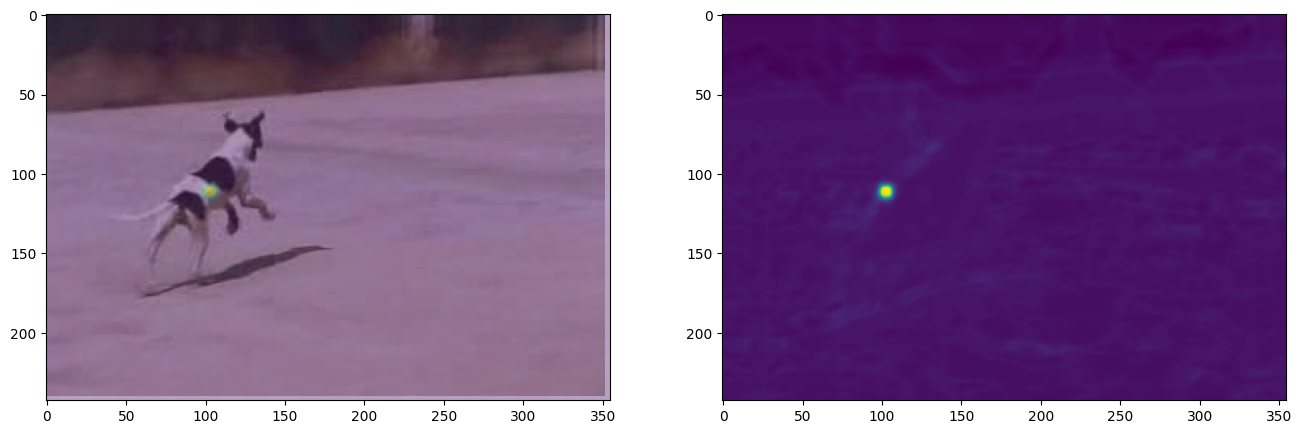

tensor(-0., device='cuda:0') tensor(2.7897, device='cuda:0')
tensor(-2776., device='cuda:0')


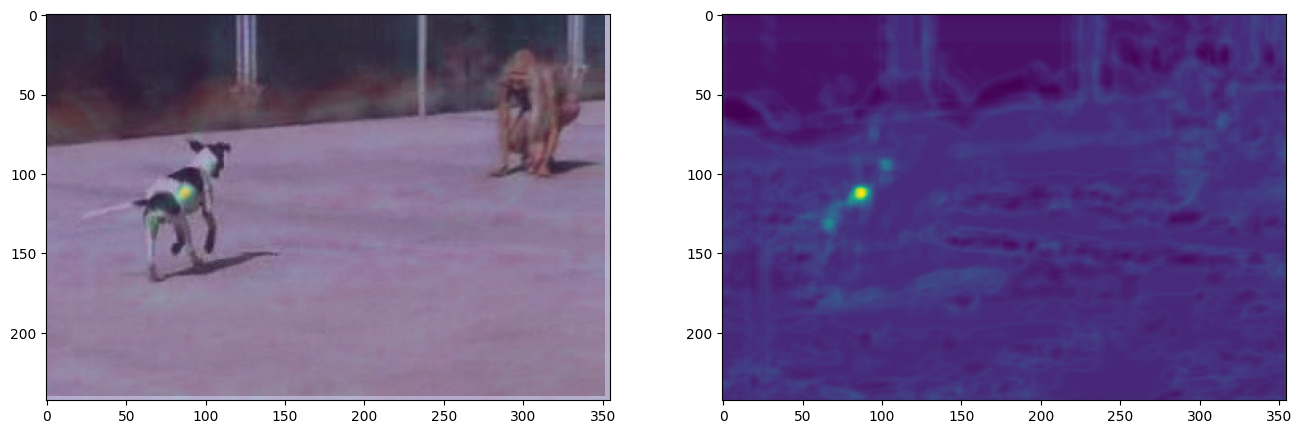

tensor(-0., device='cuda:0') tensor(3.3260, device='cuda:0')
tensor(-2776., device='cuda:0')


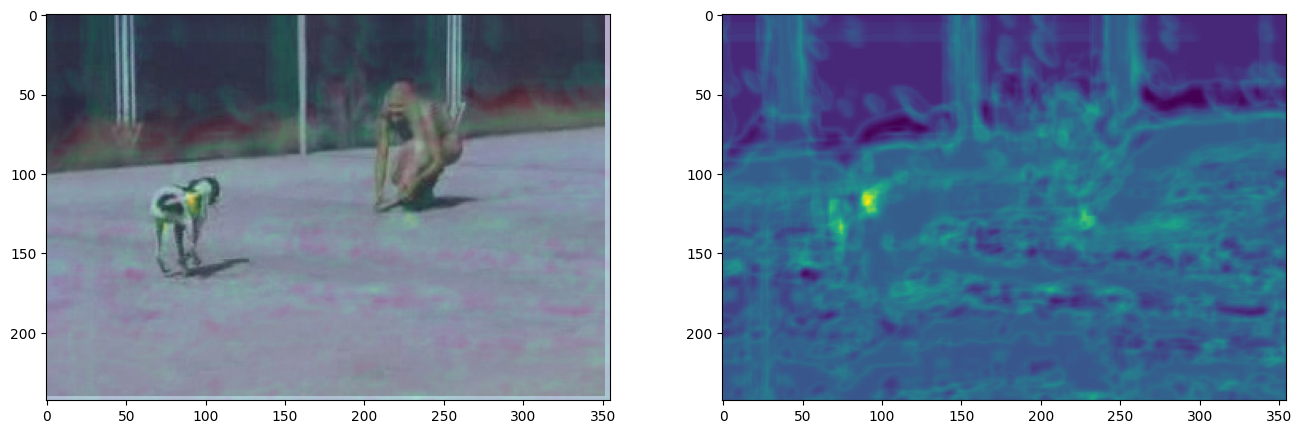

tensor(-0., device='cuda:0') tensor(2.6851, device='cuda:0')
tensor(-2776., device='cuda:0')


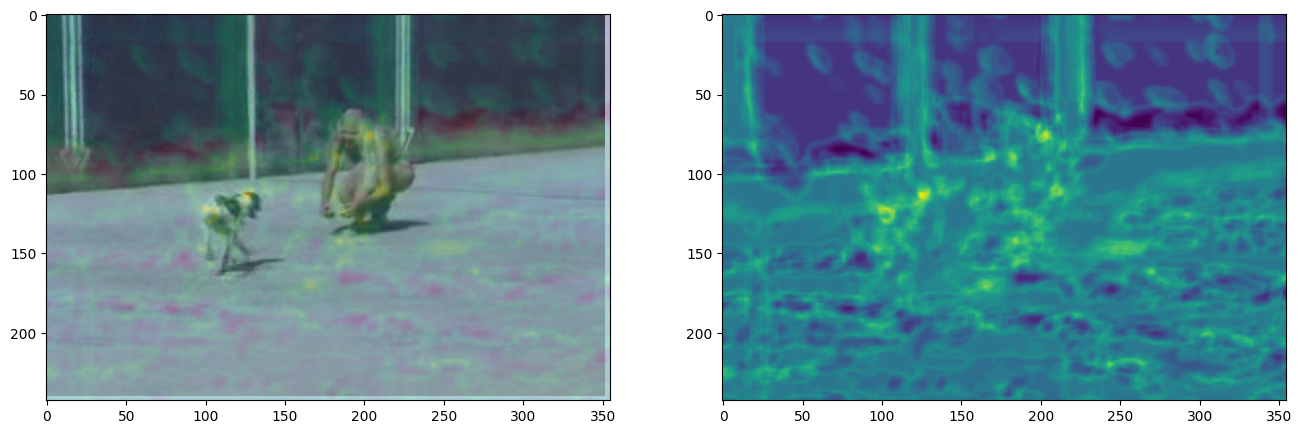

tensor(-0., device='cuda:0') tensor(3.6906, device='cuda:0')
tensor(-2781., device='cuda:0')


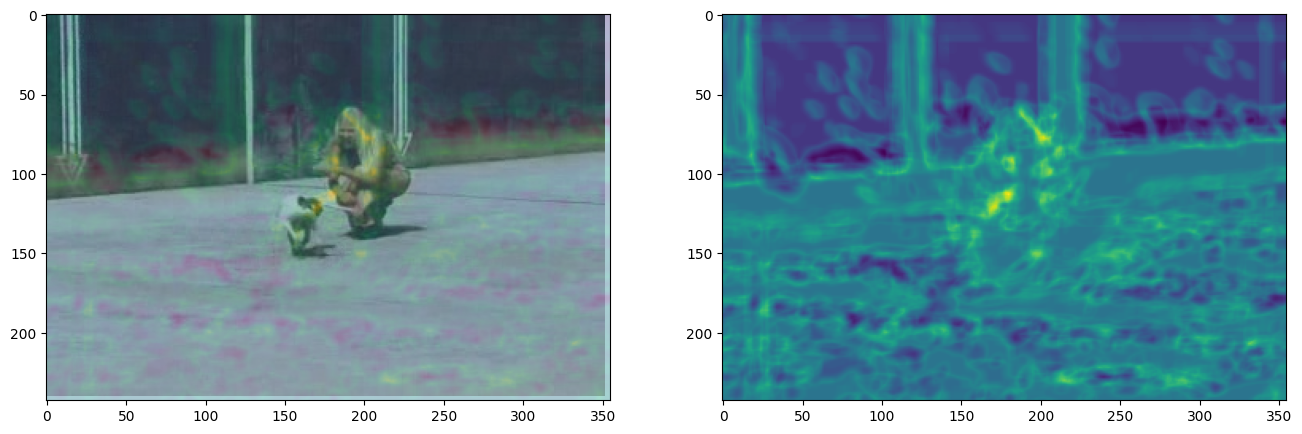

tensor(-0., device='cuda:0') tensor(3.4799, device='cuda:0')
tensor(-2781., device='cuda:0')


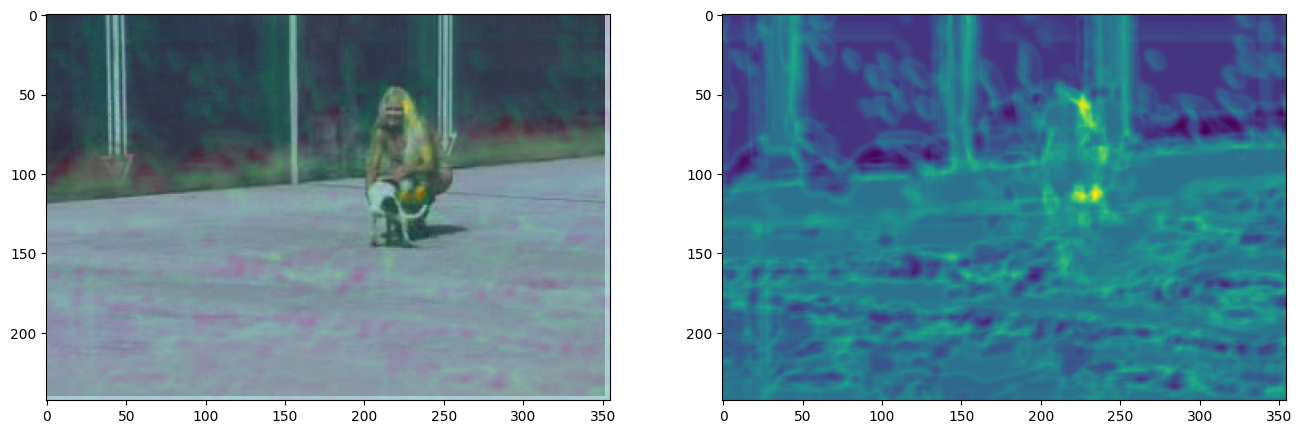

tensor(-0., device='cuda:0') tensor(2.1916, device='cuda:0')
tensor(-2776., device='cuda:0')


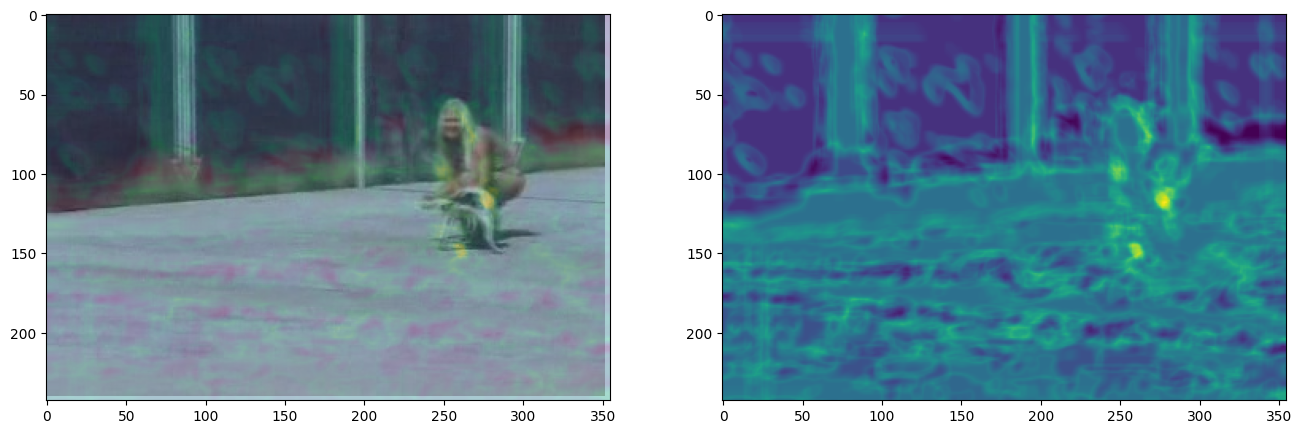

In [4]:
n_clusters = 256

augment = aug.Compose([aug.Normalize(p=1)])


feature_config = PixelFeatureExtractorConfig(
    device=0, stride_ratio=1, batch_size=128, model_name="resnet18", in_channels=3, num_features=64
)

dataset_folder = "/mnt/hdd1/users/aktgpt/datasets/Dog/img"
imgs_path = sorted(glob.glob(os.path.join(dataset_folder, "*.jpg")))
annotations = pd.read_csv(
    "/mnt/hdd1/users/aktgpt/datasets/Dog/groundtruth_rect.txt",
    header=None,
    index_col=False,
    sep="\t",
)
annotations.head()

image = cv2.cvtColor(cv2.imread(imgs_path[0]), cv2.COLOR_BGR2RGB)
# print(image.max(), image.min())
augmented = augment(image=image)
image = augmented["image"]
# print(image.max(), image.min())
feature_extractor = PixelFeatureExtractor([image], feature_config)
device = feature_extractor.device

images_features = feature_extractor.get_images_features()[0]
# print(images_features.shape, image.shape)


patch_features = images_features[
    :,
    annotations.iloc[0, 1] : annotations.iloc[0, 1] + annotations.iloc[0, 3],
    annotations.iloc[0, 0] : annotations.iloc[0, 0] + annotations.iloc[0, 2],
]
# print(patch_features.shape)

c, w, h = patch_features.shape
x = patch_features.reshape(c, w * h).transpose(1, 0)
# print(x.shape)
cluster_centers, choice_cluster, dis_vals = kmeans(X=x, num_clusters=n_clusters)
print(dis_vals.min(), dis_vals.max())
print(choice_cluster.shape, cluster_centers.shape)
_, counts = torch.unique(choice_cluster, return_counts=True)
feature_histogram = counts  # / (w * h)
feature_norm = cluster_centers.norm(dim=1, keepdim=True)

dist_calculator = nn.Conv1d(in_channels=c, out_channels=n_clusters, kernel_size=1, bias=False).to(
    feature_extractor.device
)
dist_calculator.weight.data = cluster_centers.unsqueeze(-1).to(torch.float32)
dist_calculator.weight.requires_grad = False

pool1d = nn.MaxPool1d(kernel_size=n_clusters, return_indices=True)
unpool1d = nn.MaxUnpool1d(kernel_size=n_clusters)

sum_kern = torch.nn.functional.one_hot(choice_cluster.reshape(w, h)).permute(2, 0, 1).unsqueeze(1)
sum_kern1 = dilation(sum_kern, torch.ones(5, 5).to(device))
# fig, ax = plt.subplots(nrows=8, ncols=8)
# i=0
# for row in ax:
#     for col in row:
#         col.imshow(sum_kern1[i,0,:,:].cpu().numpy())
#         i +=1
sum_dis_filter = nn.Conv2d(
    n_clusters,
    n_clusters,
    (w, h),
    padding=(w // 2 + 1, h // 2 + 1),
    padding_mode="reflect",
    groups=n_clusters,
    bias=False,
).to(device)
# sum_dis_filter.weight.data = torch.ones(n_clusters, 1, w, h).to(device).to(torch.float32) #/ (w * h)
sum_dis_filter.weight.data = sum_kern1
# / sum_kern1.sum(dim=(1, 2, 3)).unsqueeze(-1).unsqueeze(
# -1
# ).unsqueeze(-1)
sum_dis_filter.weight.requires_grad = False

for i in range(1, len(imgs_path), 20):
    # for img_path in imgs_path[85:95]:
    img = cv2.cvtColor(cv2.imread(imgs_path[i]), cv2.COLOR_BGR2RGB)
    augmented = augment(image=img)
    img_aug = augmented["image"]
    image_features = feature_extractor.get_image_features(img_aug)[0]
    # print(image_features.shape)

    kl, (_, det_x, det_y) = max_locs(
        image_features,
        cluster_centers,
        sum_dis_filter,
        feature_norm,
        pool1d,
        unpool1d,
        feature_histogram,
        n_chunks=1024,
    )
    print(kl.min())
    # x, y, w, h = annotations.iloc[0, :].values
    # print(x, y, w, h)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 12))
    ax[0].imshow(img)
    ax[0].imshow(kl[0].cpu().numpy(), alpha=0.4)
    ax[1].imshow(kl[0].cpu().numpy())
    plt.show()
    # rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
    # ax.add_patch(rect)
    # rect_det = patches.Rectangle(
    #     (det_x[0].cpu().numpy(), det_y[0].cpu().numpy()),
    #     w,
    #     h,
    #     linewidth=1,
    #     edgecolor="g",
    #     facecolor="none",
    # )
    # ax.add_patch(rect_det)
